In [1]:
import h5py
import numpy as np
from skimage.transform import resize
from skimage import color
from skimage import segmentation
import matplotlib.pyplot as plt
import time
import IPython

%load_ext autoreload
%autoreload 2
%matplotlib inline

def scale_data(vol, seg, size=180):
    length = vol.shape[0]
    vol = resize(vol, (length, size, size))
    seg = resize(seg, (length, size, size), order=0, preserve_range=True, anti_aliasing=False)

    return (vol, seg)
    
def label_data(vol, seg):
    length = vol.shape[0]
    size = vol.shape[1]
    # reshape for labeling
    seg = np.reshape(seg, (size, length*size) )
    vol = np.reshape(vol, (size, length*size) )
    # label
    labeled = color.label2rgb(seg, vol, alpha=0.08, bg_label=-1)
    # shape back
    labeled = np.reshape(labeled, (length, size, size, 3) )

    return labeled

def vis_volume(volume):
    length = volume.shape[0]
    
    # set up
    fig = plt.figure()
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], interpolation='none', filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()

def view_patch(patch,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(16, 10)
    axarr[0,0].imshow(patch.image[0][i], cmap='gray')
    axarr[0,1].imshow(patch.label[0][i])
    axarr[0,2].imshow(label_data(patch.image[0],patch.label[0])[i])
    axarr[1,0].imshow(patch.affinity[0][i])
    axarr[1,1].imshow(patch.affinity[1][i])
    axarr[1,2].imshow(patch.affinity[2][i])
    axarr[2,0].imshow(patch.get_lsd_channel(0)[i,:,:,0])
    axarr[2,1].imshow(patch.get_lsd_channel(1)[i,:,:,0])
    axarr[2,2].imshow(patch.get_lsd_channel(2)[i,:,:,0])
    axarr[2,3].imshow(patch.get_lsd_channel(3)[i], cmap='gray')
    plt.show()

In [54]:
from neutorch.dataset.utils import from_h5
path = '../../data'
fileA = 'sample_A'
fileB = 'sample_B'
fileC = 'sample_C'
imageA = from_h5(f'{path}/{fileA}.hdf', dataset_path='volumes/raw')
imageB = from_h5(f'{path}/{fileB}.hdf', dataset_path='volumes/raw')
imageC = from_h5(f'{path}/{fileC}.hdf', dataset_path='volumes/raw')

In [ ]:
size =180
length = imageA.shape[0]
imageA_small = resize(vol, (length, size, size))

In [4]:
from neutorch.dataset.affinity import Dataset
from neutorch.dataset.ground_truth_volume import *

dataset = Dataset('../../data', patch_size=(8,80,80))

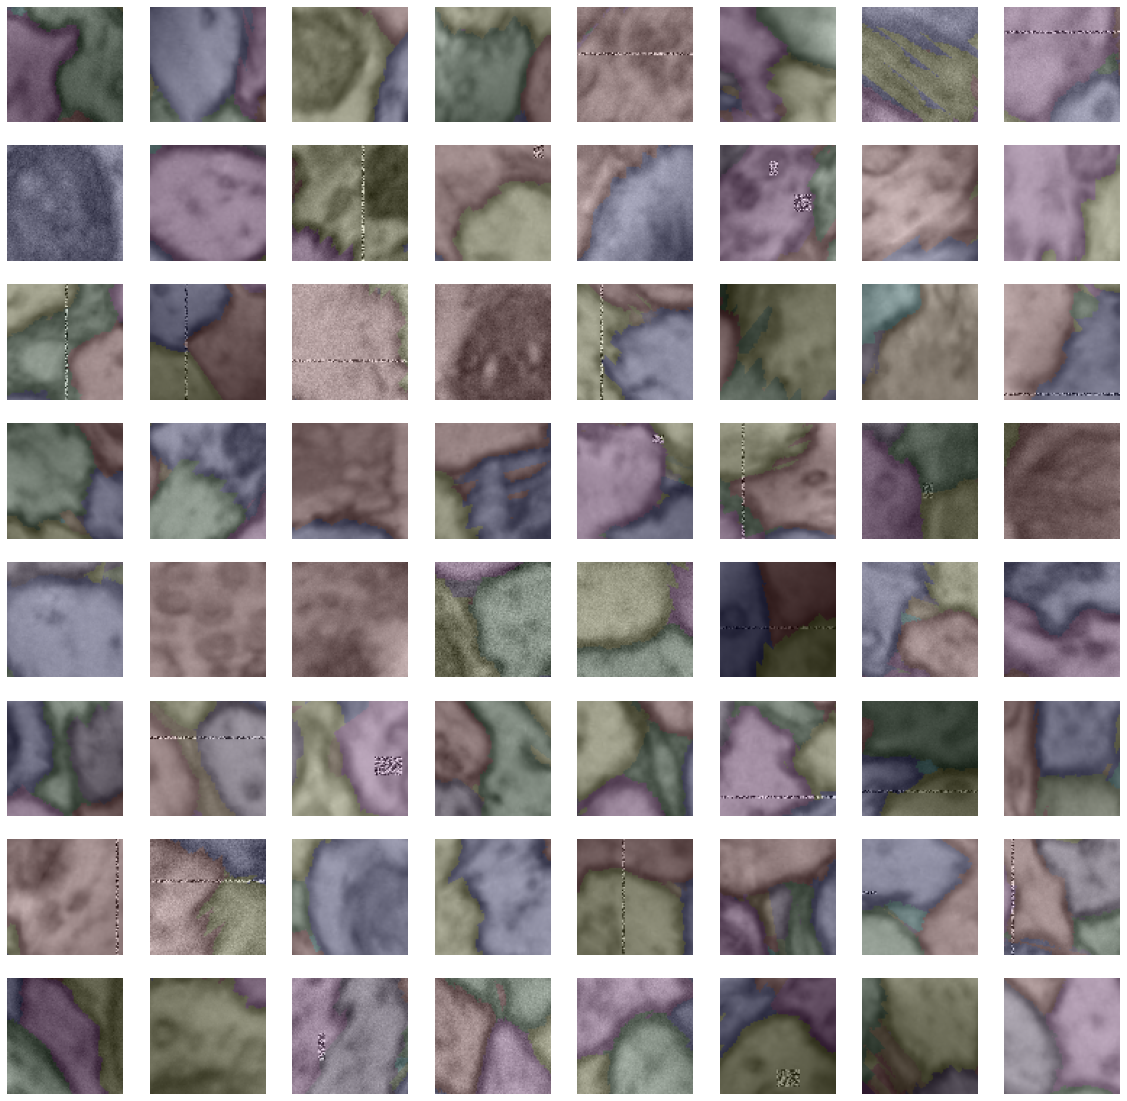

In [5]:
num_plot = 8
i = 0
fig, axarr = plt.subplots(num_plot,num_plot)
fig.set_size_inches(20, 20)

for i in range(num_plot):
    for j in range(num_plot):
        patch = dataset.random_training_patch
        labeled_data = label_data(patch.image[0],patch.label[0])
        axarr[i,j].imshow(labeled_data[i])

[axi.set_axis_off() for axi in axarr.ravel()]
plt.show()

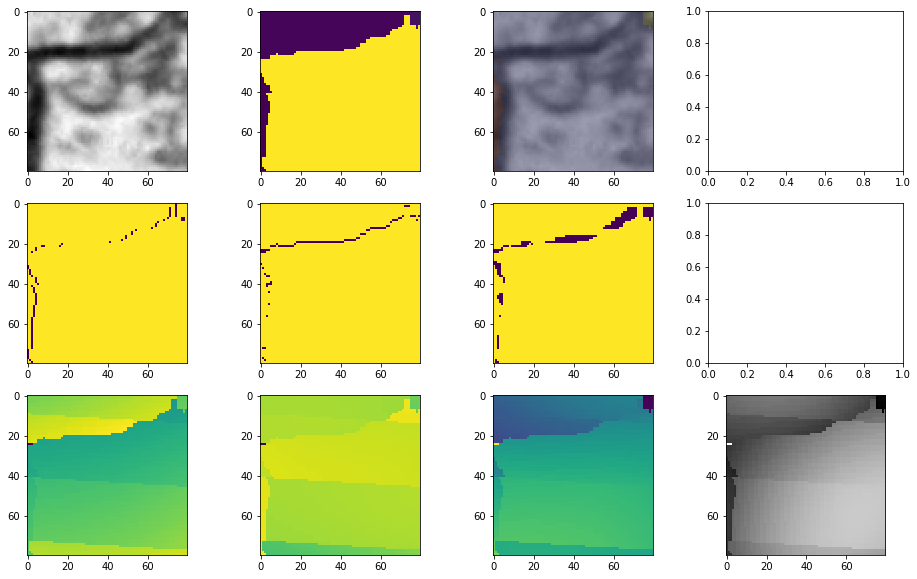

In [24]:
patch = dataset.random_training_patch
view_patch(patch)

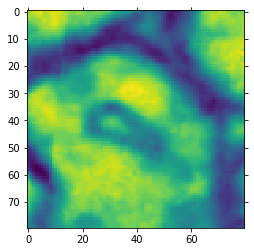

In [53]:
patch = dataset.random_training_patch
vis_volume(np.squeeze(patch.image))